# Frequency-Domain Analysis of Large Datasets

## Author(s)
**Paige Martin and Ryan Abernathey**

- Author1 = {"name": "Paige Martin", "affiliation": "Australian National University/Lamont-Doherty Earth Observatory", "email": "paigemar@umich.edu", "orcid": "0000-0003-3538-633X"}
- Author2 = {"name": "Ryan Abernathey", "affiliation": "Lamont-Doherty Earth Observatory", "email": "rpa@ldeo.columbia.edu", "orcid": "0000-0001-5999-4917"}

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Template-Notebook-for-EarthCube---Long-Version" data-toc-modified-id="Template-Notebook-for-EarthCube---Long-Version-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Template Notebook for EarthCube - Long Version</a></span><ul class="toc-item"><li><span><a href="#Author(s)" data-toc-modified-id="Author(s)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Author(s)</a></span></li><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Technical-contributions" data-toc-modified-id="Technical-contributions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Technical contributions</a></span></li><li><span><a href="#Methodology" data-toc-modified-id="Methodology-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Methodology</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Funding" data-toc-modified-id="Funding-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Funding</a></span></li><li><span><a href="#Keywords" data-toc-modified-id="Keywords-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Keywords</a></span></li><li><span><a href="#Citation" data-toc-modified-id="Citation-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Citation</a></span></li><li><span><a href="#Work-In-Progress---improvements" data-toc-modified-id="Work-In-Progress---improvements-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Work In Progress - improvements</a></span></li><li><span><a href="#Suggested-next-steps" data-toc-modified-id="Suggested-next-steps-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Suggested next steps</a></span></li><li><span><a href="#Acknowledgements" data-toc-modified-id="Acknowledgements-1.11"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>Acknowledgements</a></span></li></ul></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Library-import" data-toc-modified-id="Library-import-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Library import</a></span></li><li><span><a href="#Local-library-import" data-toc-modified-id="Local-library-import-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Local library import</a></span></li></ul></li><li><span><a href="#Parameter-definitions" data-toc-modified-id="Parameter-definitions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parameter definitions</a></span></li><li><span><a href="#Data-import" data-toc-modified-id="Data-import-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data import</a></span></li><li><span><a href="#Data-processing-and-analysis" data-toc-modified-id="Data-processing-and-analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data processing and analysis</a></span><ul class="toc-item"><li><span><a href="#The-10-rules" data-toc-modified-id="The-10-rules-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>The 10 rules</a></span></li><li><span><a href="#Using-notebook-template" data-toc-modified-id="Using-notebook-template-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Using notebook template</a></span></li><li><span><a href="#Adding-table-of-contents" data-toc-modified-id="Adding-table-of-contents-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Adding table of contents</a></span></li><li><span><a href="#Creating-Binder-and-Docker-for-your-notebook-repository" data-toc-modified-id="Creating-Binder-and-Docker-for-your-notebook-repository-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Creating Binder and Docker for your notebook repository</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Purpose

Climate model datasets are typically stored as global snapshots, i.e. chunked in time rather than space. For many workflows, this chunking works well (e.g. computations across spatial domains at every point in time). However, this storage format can create serious challenges for processing long time series at each point in space, as is the case for frequency-domain analysis. For large datasets with frequent (e.g. daily) output, it is not feasible to process each spatial point as a single time series, even with the help of distributed computing such as Dask.

This notebook provides an example scientific workflow for performing frequency-domain analysis on large datasets. Specifically, this notebook presents a workflow for computing the power spectrum of sea surface temperature in the [Community Earth System Model](https://www.cesm.ucar.edu) (CESM). While we carry out computations on a specific model, the main goal of this notebook is not to interpret scientific results from our computations, but rather to provide a working example of frequency-domain analysis on large datasets that others could follow.

Because the goal of this notebook is to provide an example of a workflow that works on large datasets, we have chosen to use a large dataset (CESM) that is available on Pangeo Cloud. This notebook is therefore developed for a Jupyter Hub environment that can access data stored on the Pangeo Cloud (e.g. [PangeoBinder](https://binder.pangeo.io)).


## Technical contributions

- demonstrates how to quickly rechunk data, e.g. from chunks in time to chunks in space, using the package [rechunker](https://rechunker.readthedocs.io/en/latest/)
- demonstrates how to easily perform Fourier analysis using the package [xrft](https://xrft.readthedocs.io/en/latest/)
- shows that all of these steps, with the use of [Xarray](http://xarray.pydata.org/en/stable/) and [Dask](https://dask.org) can be taken with large datasets


## Methodology

The notebook follows three main steps:

1) Rechunk the data. We begin by rechunking the CESM sea surface temperature (SST) output from global, daily snapshots to chunks in space and 5-year chunks in time. This step is accomplished using the package `rechunker`. 

2) Fourier analysis. Next we compute the power spectrum of SST using the package `xrft`, which nicely integrates with `Xarray` and `Dask`. Within `xrft`, we are also able to easily apply detrending and windowing functions to our data, and also account for the fact that our data are real (with no imaginary components).

3) Visualize the data. Last, we average over various frequency bands to show the spatial distribution of the SST power spectrum as global maps.

Between each of these steps, we would typically write out the intermediate data. So we would write out the rechunked data, as well as the processed power spectra. Being able to write out data at intermediate steps is crucial to this workflow. However, due to the inability to write out data from Binder, we instead import previously processed data in this notebook. We still include all of the code necessary to run all of the steps if a user wishes to run this notebook elsewhere that allows for data to be written out.


## Results
This notebook presents a feasible example for performing frequency-domain analysis on large datasets. Specifically, this notebook demonstrates how to quickly rechunk ~500GB of data from chunking in time to chunking in space. It also demonstrates how to pair the `xrft` library with the rechunked data to take Fourier Transforms (here power spectra) and obtain interpretable results. We finish with a few sample plots to round out the workflow. This notebook is meant to serve as an example for others who wish to perform similar types of analysis.


## Funding

- Award1 = {"agency": "Gordon and Betty Moore Foundation", "award_code": "", "award_URL": "https://www.moore.org"}

## Keywords

keywords=["frequency-domain", "Pangeo", "Fourier analyis", "rechunking", "cloud computing"]

## Citation

Martin and Abernathey 2021. Frequency-Domain Analysis of Large Datasets. Accessed at **link**.

## Acknowledgements 

We thank the Pangeo community for developing and maintaining most of the packages used in this notebook. We also acknowledge Pangeo Cloud, which provides the computing power for this analysis. 

# Setup

## Library import

In [1]:
# Reading in data
import intake
import gcsfs
import zarr
import os

# Data manipulation
import xarray as xr
import dask.array as dsa
from rechunker import rechunk
import xrft

# Distributed computing
from dask_gateway import Gateway
from dask.distributed import Client

# Visualization
import cmocean
import matplotlib.pyplot as plt

# Data import, processing, and analysis

***

# Step 1: Rechunk the data

### Here we rechunk the sea surface temperature output from the Community Earth System Model (CESM) 

This dataset is stored on the Pangeo Cloud and contains daily output for 41 model years. Using Dask distributed computing, we perform the rechunking of the data and save directly to my GCS storage bucket. Because this Binder instance does not allow for the writing of data, we display the steps we take to do the rechunking below, and then continue with the Fourier transform steps after by loading in a dataset that was rechunked using the method described below.

### Access the data

In [2]:
# Access CESM output from Pangeo Cloud data catalog
cat = intake.open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml")
item = cat['CESM_POP_hires_control'] # Specify CESM high resolution control run

# Open data as Zarr group
gcs = gcsfs.GCSFileSystem(requester_pays=True) # Connect to Google Cloud Storage (GCS)
mapper = gcs.get_mapper(item.urlpath) # gcs.get_mapper() is like getting the pathname of the data on GCS
zgroup = zarr.open_consolidated(mapper) # Open the dataset in Zarr format

# Select SST variable
varname = 'SST' # name of variable you wish to rechunk (SST in this case)
array = zgroup[varname] # select only the SST variable from the Zarr group

## Rechunk a single Zarr array

Since we are only interested in specific variables, we rechunk a single variable (in this case SST) at a time.

In [3]:
# Write intermediary data to a temporary path. Items stored here get deleted every 7 days.
scratch_path = os.environ['PANGEO_SCRATCH']
scratch_path

'gs://pangeo-scratch/paigem/'

### Rechunk the data

The following cells demonstrate how we rechunk CESM SST data. In our typical scientific workflow, we would rechunk the data and save directly to Zarr. However, due to the fact that we are working with large data files and the restriction from writing data from Binder, these cells are not executable in this notebook. These cells are thus supplied below in Markdown format.

```python
# Define options needed by the `rechunk()` function of `rechunker`.
max_mem = '1GB' # request memory for dask workers
target_chunks = (365*5, 90, 180) # chunk in time (5 years) and space

# Set paths to temporary and target storage locations and set names of output data
tmp_path = f'{scratch_path}/CESM_POP_hires_control/{varname}_tmp_earthcube_TEST.zarr'
target_path = f'{scratch_path}/CESM_POP_hires_control/{varname}_target_earthcube_TEST.zarr'
```

```python
# Delete arrays of the same name that already exist at those paths
def clear_targets():
    for path in tmp_path,target_path:
        try:
            gcs.rm(path + '/.zarray')
        except FileNotFoundError:
            pass
clear_targets()
```

```python
# Create mappings to temporary and target storage buckets
store_tmp = gcs.get_mapper(tmp_path)
store_target = gcs.get_mapper(target_path)
```

```python
# Call the `rechunk()` function. Below it shows the type of the source, intermediate, and target data.
r = rechunk(array, target_chunks, max_mem,
            store_target, temp_store=store_tmp, executor='dask')
r
```

### (Set up Dask cluster)

Note that to successfully run `rechunk()` it is necessary to spin up a Dask cluster. To see how we do so on Pangeo Cloud using Dask Gateway, see the following section on computing the power spectrum.

#### Execute the `rechunk()` function

```python
%%time
r.execute(retries=10) # `retries=10` sets the number of times a Dask worker will retry if computing fails (default is 0)
```

***

# Step 2: Compute the power spectrum of SST

The power spectrum is defined as follows, where a hat denotes a Fourier transform and the star denotes a complex conjugate.

$$
\widehat{SST}^* \widehat{SST}
$$

Here we read in the rechunked SST field obtained by following all of the above steps. 

In [5]:
# Read previously rechunked data from my GCS storage bucket
varname = 'SST' 
target_path = f'pangeo-paigem/CESM_POP_hires_control/{varname}_target.zarr'
Tda = dsa.from_zarr(gcs.get_mapper(target_path)) # load as dask file

In [4]:
Tda

,Array,Chunk
Bytes,517.19 GB,118.26 MB
Shape,"(14965, 2400, 3600)","(1825, 90, 180)"
Count,4861 Tasks,4860 Chunks
Type,float32,numpy.ndarray


### Work with a 10-year subset of the rechunked data

Though we only show the workflow for one 10-year subset below, when running this workflow for scientific output we compute the power spectrum across several (in this case 10-year) windows. By averaging over all windows in our final plots, we are able to smooth out the naturally noisy Fourier Transform while also getting better statistics. 

In [6]:
# Create 10-year subset over first 10 years of output
yr1 = 0
yr2 = 10

Tda = Tda[365*yr1:365*yr2,:,:]

# Convert from dask to xarray DataArray
Txr = xr.DataArray(Tda,dims=['time','nlat','nlon'])

### Define function to take power spectrum

In [7]:
def take_power_spectrum(var,real_arg):
    
    var = var.chunk({'time':None}) # there can be no chunking in the time dimension
    var_filled = var.fillna(0) # fill NaNs with zeros
    
    # Take power spectrum in the time domain, setting time to be a real dimension, with both a linear detrend and a windowing function
    var_hat = xrft.power_spectrum(var_filled,dim='time',real=real_arg,detrend='linear',window=True)
    
    return var_hat

### Start Dask cluster

This Dask cluster sets each worker to use 12 GB of memory, and allows for up to 20 workers to spin up (using adaptive scaling).

In [11]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()
options.worker_memory = 12 # assign each worker 12 GB of memory
cluster = gateway.new_cluster(options)
cluster.adapt(minimum=1, maximum=20) # use adaptive scaling to allow up to 20 workers
cluster # print out cluster information - you can use this to view when the cluster spins up

In [12]:
# Start the client
from dask.distributed import Client
client = Client(cluster)
client # the link below can be used to access the Dask dashboard

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.5e2c48b145834c45b36541b1f205d866 Dashboard: /services/dask-gateway/clusters/prod.5e2c48b145834c45b36541b1f205d866/status,Cluster Workers: 1 Cores: 2 Memory: 12.88 GB


### Compute the power spectrum of SST

In [30]:
# Call the
T_fft = take_power_spectrum(Txr,'time')

# Take only the real output, and immediately coarsen to 0.5 degree grid to reduce the file size
T_power_spectrum = T_fft.real.coarsen(nlat=5,nlon=5).mean() #.load()

In [31]:
T_power_spectrum_reset = T_power_spectrum.reset_coords(names='freq_time_spacing',drop=True) # remove added coordinate that is not needed
T_power_spectrum_reset

,Array,Chunk
Bytes,5.05 GB,9.47 MB
Shape,"(480, 720, 1826)","(18, 36, 1826)"
Count,16206 Tasks,540 Chunks
Type,float64,numpy.ndarray


### Write to Zarr

Here is when we would write out the power spectrum computation in our scientific workflow. However, we again include this cell as Markdown only since Binder does not have write access. Additionally, we are unable to keep `T_power_spectrum_reset` in memory as it is over 5GB. In the next plotting step, we load in power spectrum data that was previously computed using this exact method.

```python
# Set path to save power spectrum
url = f'{scratch_path}/CESM_POP_hires_control/SST_power_spectrum_yr{yr1}_{yr2}_earthcube_test.zarr'

# Save to Zarr
T_power_spectrum_reset.to_dataset(name='SST_power_spectrum').to_zarr(gcs.get_mapper(url)) # need to convert xarray DataArray to Dataset first
```

***

# Step 3: Plot in frequency bands

### Load previously computed power spectrum data.

In [8]:
# Set path to save power spectrum
url = f'{scratch_path}/CESM_POP_hires_control/SST_power_spectrum_yr{yr1}_{yr2}_earthcube_test.zarr'

T_ps = xr.open_zarr(gcs.get_mapper(url)) # open Zarr data saved using xarray

### Load original dataset in order to define a land mask

This step is necessary because the original land mask (i.e. land regions designated by Nan) was removed when we set all of the NaN values to zero before taking the power spectrum.

In [3]:
ds = cat['CESM_POP_hires_control'].to_dask() 
SST_mask = ds.SST.isel(time=0).coarsen(nlat=5,nlon=5).mean()

### Plot the result 

Here we average across frequency bands (as labeled in the subplot titles) in order to visualize the power spectrum spatially as global maps.

CPU times: user 4.16 s, sys: 533 ms, total: 4.7 s
Wall time: 40.5 s


Text(0.5, 1.0, 'Power spectrum (1 - 10 days)')

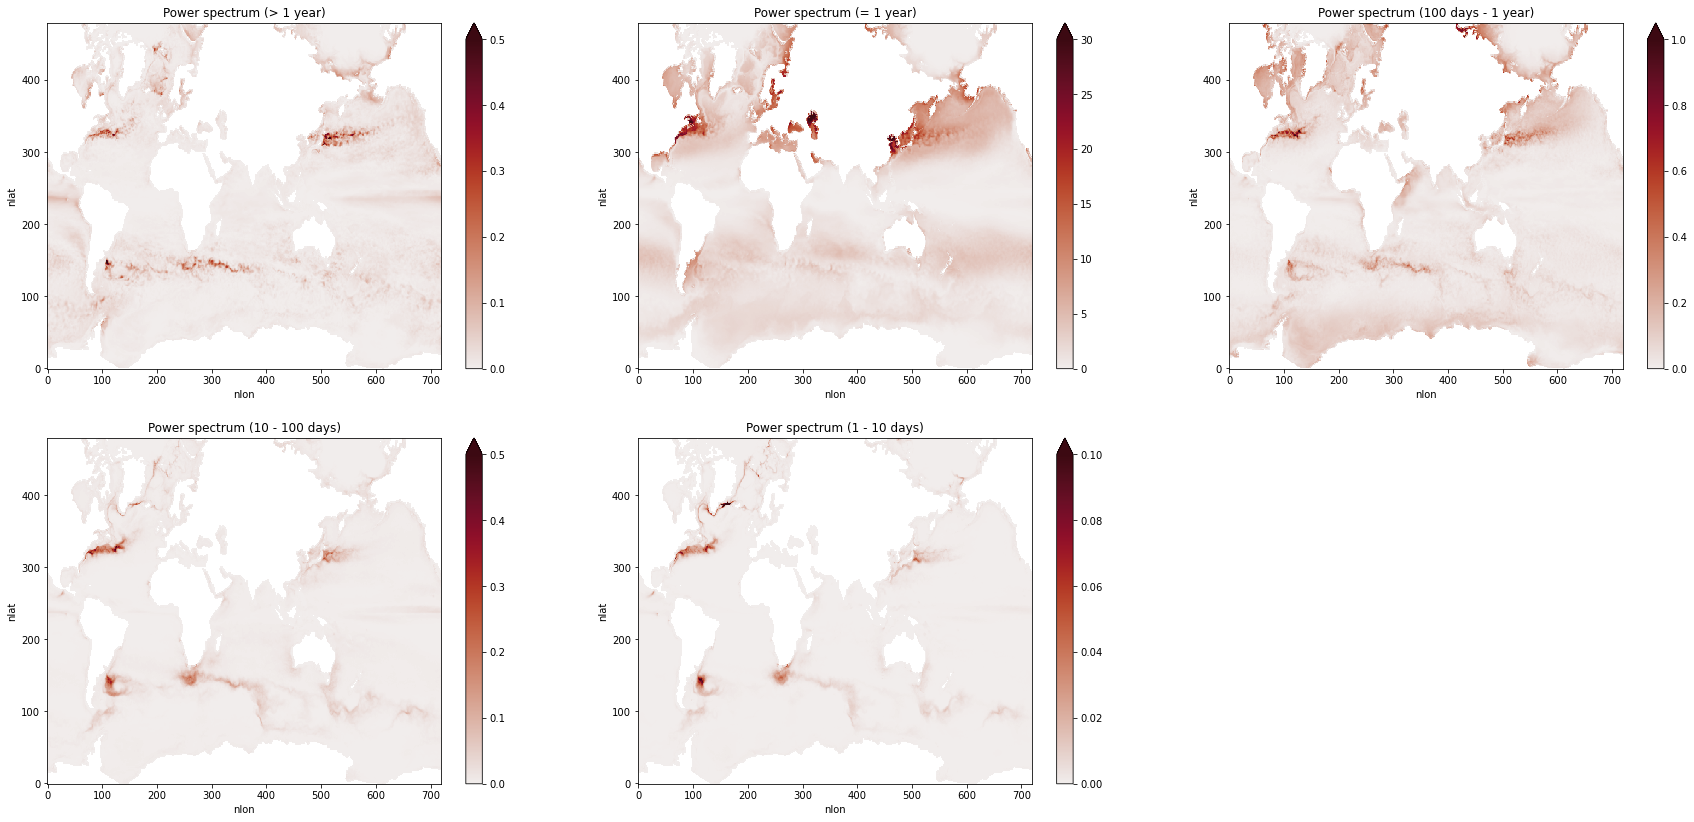

In [30]:
%%time
plt.figure(figsize=(30,14))

plt.subplot(231)
T_ps_plot = (T_ps.SST_power_spectrum.isel(freq_time=slice(1,9))*T_ps.freq_time.isel(freq_time=slice(1,9))).mean('freq_time')
T_ps_plot.where(SST_mask.notnull()).plot(vmin=0,vmax=0.5,cmap=cmocean.cm.amp)
plt.title('Power spectrum (> 1 year)')
plt.subplot(232)
T_ps_plot = (T_ps.SST_power_spectrum.isel(freq_time=slice(9,12))*T_ps.freq_time.isel(freq_time=slice(9,12))).mean('freq_time')
T_ps_plot.where(SST_mask.notnull()).plot(vmin=0,vmax=30,cmap=cmocean.cm.amp)
plt.title('Power spectrum (= 1 year)')
plt.subplot(233)
T_ps_plot = (T_ps.SST_power_spectrum.isel(freq_time=slice(12,36))*T_ps.freq_time.isel(freq_time=slice(12,36))).mean('freq_time')
T_ps_plot.where(SST_mask.notnull()).plot(vmin=0,vmax=1,cmap=cmocean.cm.amp)
plt.title('Power spectrum (100 days - 1 year)')
plt.subplot(234)
max_val = 0.00035
T_ps_plot = (T_ps.SST_power_spectrum.isel(freq_time=slice(36,366))*T_ps.freq_time.isel(freq_time=slice(36,366))).mean('freq_time')
T_ps_plot.where(SST_mask.notnull()).plot(vmin=0,vmax=0.5,cmap=cmocean.cm.amp)
plt.title('Power spectrum (10 - 100 days)')
plt.subplot(235)
max_val = 7e-5
T_ps_plot = (T_ps.SST_power_spectrum.isel(freq_time=slice(366,None))*T_ps.freq_time.isel(freq_time=slice(366,None))).mean('freq_time')
T_ps_plot.where(SST_mask.notnull()).plot(vmin=0,vmax=0.1,cmap=cmocean.cm.amp)
plt.title('Power spectrum (1 - 10 days)')